<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/CNN4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data already downloaded.


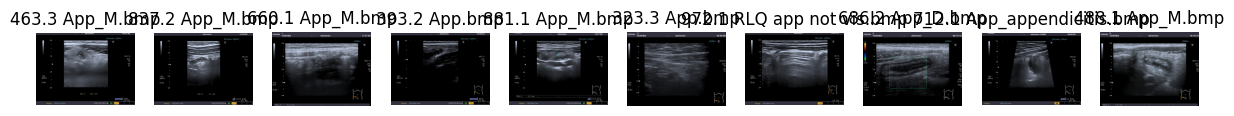

Loading and preprocessing data...
Loaded and preprocessed data with 760 entries
Processing and saving images...


Processing images: 100%|██████████| 2098/2098 [01:14<00:00, 28.26it/s]


Initializing MedicalImagesDataset...
Initialized MedicalImagesDataset with 2503 images.
Dataset initialized with 2503 samples
Reassigning US numbers...
Reassignment completed.
Initializing PatientDataset...
Initialized PatientDataset with 621 patients.
Training set size: 397
Validation set size: 99
Test set size: 125


100%|██████████| 25/25 [04:29<00:00, 10.79s/it]


Before training
Train Loss: 0.6979, Train Acc: 0.3829, Train ROC AUC: 0.6328
Val Acc: 0.3939, Val ROC AUC: 0.6615


Epoch 1/10 [Validation]: 100%|██████████| 7/7 [00:59<00:00,  8.50s/it]


Epoch 1/10
Train Loss: 0.7631, Train Acc: 0.6045, Train ROC AUC: 0.5929
Val Acc: 0.8990, Val ROC AUC: 0.9846


Epoch 2/10 [Validation]: 100%|██████████| 7/7 [01:00<00:00,  8.60s/it]


Epoch 2/10
Train Loss: 0.3781, Train Acc: 0.8665, Train ROC AUC: 0.9380
Val Acc: 0.9091, Val ROC AUC: 0.9970


Epoch 3/10 [Training]:  60%|██████    | 15/25 [05:08<03:25, 20.52s/it]

In [ ]:
# Imports
import os
import re
import random
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display, HTML
from sklearn.model_selection import StratifiedKFold

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# TensorBoard writer
writer = SummaryWriter()

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 230)

# Seed settings
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed_all(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Directory and file paths
raw_image_path = '/content/US_Pictures/US_Pictures/'
image_path = '/content/US_Pictures/US_Pictures/Preprocessed/'
zip_path = '/content/US_Pictures.zip'
data_url = "https://raw.githubusercontent.com/Dicti93/MLSEM/master/2.%20Data%20and%20Description/data.csv"
model_path = 'model.pth'

# Hyperparameters and constants
learning_rate = 0.0001
num_epochs = 10
batch_size = 16
threshold = 10
early_stopping_patience = 5

# Ensure the required directories exist
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)
        logger.info(f"Directory created: {path}")
        print(f"Directory created: {path}")

ensure_directory_exists(raw_image_path)
ensure_directory_exists(image_path)

# Download and extract data if necessary
def download_and_extract_data():
    if not os.listdir(raw_image_path) or not any(f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')) for f in os.listdir(raw_image_path)):
        logger.info("Downloading data...")
        print("Downloading data...")
        os.system(f'wget -O {zip_path} https://zenodo.org/records/7669442/files/US_Pictures.zip')
        os.system(f'unzip -q {zip_path} -d /content/US_Pictures/')
    else:
        logger.info("Data already downloaded.")
        print("Data already downloaded.")

download_and_extract_data()

# Display first five images
def display_images(image_path, num_images=10):
    files = [f for f in os.listdir(image_path) if f.endswith(('.png', '.bmp'))][:num_images]
    if not files:
        logger.warning("No image files found in the directory.")
        print("No image files found in the directory.")
        return
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(image_path, file))
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(file)
    plt.show()

display_images(raw_image_path)

# Load and preprocess dataset
def load_and_preprocess_data(data_url):
    print("Loading and preprocessing data...")
    data = pd.read_csv(data_url, delimiter=';')
    columns_to_drop = [
        'Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Management', 'Severity',
        'Diagnosis_Presumptive', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US',
        'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness',
        'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage',
        'Segmented_Neutrophils', 'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
        'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis',
        'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers',
        'Target_Sign', 'Appendicolith', 'Perfusion', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
        'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location', 'Bowel_Wall_Thickening',
        'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis', 'Gynecological_Findings'
    ] + [f'Unnamed: {i}' for i in range(58, 69)]
    data.drop(columns=columns_to_drop, inplace=True)
    data['Diagnosis'].replace({'appendicitis': 1, 'no appendicitis': 0, np.nan: 0}, inplace=True)
    data.dropna(subset=['US_Number'], inplace=True)
    data['US_Number'] = data['US_Number'].astype(int)
    data['Diagnosis'] = data['Diagnosis'].astype(int)
    id_to_label = {int(row['US_Number']): row['Diagnosis'] for index, row in data.iterrows()}
    print(f"Loaded and preprocessed data with {len(id_to_label)} entries")
    return id_to_label

id_to_label = load_and_preprocess_data(data_url)
logger.info(f"Loaded and preprocessed data with {len(id_to_label)} entries")

# Calculate mean and std for normalization
# print("Calculating mean and std for normalization...")
# dataset_for_norm = datasets.ImageFolder(raw_image_path, transform=transforms.ToTensor())
# dataloader_for_norm = DataLoader(dataset_for_norm, batch_size=64, shuffle=False)

# mean = 0.
# std = 0.
# nb_samples = 0.

# for data in dataloader_for_norm:
#     batch_samples = data[0].size(0)
#     data = data[0].view(batch_samples, data[0].size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

# print('Calculated Mean:', mean)
# print('Calculated Std:', std)

# Define the transformation pipeline using calculated mean and std
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7105, 0.7467, 0.3402], std=[0.2721, 0.3070, 0.2304])
])

# Process and save images
def process_and_save_images(root_dir, output_dir, transform):
    ensure_directory_exists(output_dir)
    print("Processing and saving images...")
    for filename in tqdm(os.listdir(root_dir), desc="Processing images"):
        file_path = os.path.join(root_dir, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                with Image.open(file_path).convert('RGB') as img:
                    transformed_tensor = transform(img)
                    transformed_img = TF.to_pil_image(transformed_tensor)
                    output_file_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.png')
                    transformed_img.save(output_file_path, format='PNG')
            except Exception as e:
                logger.error(f"Failed to process {filename}: {str(e)}")
                print(f"Failed to process {filename}: {str(e)}")

process_and_save_images(raw_image_path, image_path, transform)

class MedicalImagesDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None, augment=False):
        self.root_dir = root_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.augment = augment
        self.filename_mapping = {}
        self.unique_us_numbers = set()
        self.diagnosis_count_per_image = defaultdict(int)
        self.augmented_count_per_image = defaultdict(int)
        self.num_images_found = 0

        print("Initializing MedicalImagesDataset...")
        for filename in os.listdir(root_dir):
            self.num_images_found += 1
            base_name = filename.split(' ')[0]
            match = re.match(r"([0-9]+(?:\.[0-9]+)?)", base_name)
            if match:
                image_number = int(match.group(1).split('.')[0])
                label = labels_dict.get(image_number)
                if label is not None:
                    self.unique_us_numbers.add(image_number)
                    self.diagnosis_count_per_image[label] += 1
                    image_path = os.path.join(root_dir, filename)
                    image = Image.open(image_path).convert('RGB')
                    processed_image = self.transform(image) if self.transform else image
                    self.filename_mapping[filename] = (processed_image, label)

                    if self.augment and label == 0:
                        augmented_images = self.augment_image(image, 2, filename)
                        for aug_filename, aug_image in augmented_images.items():
                            self.filename_mapping[aug_filename] = (aug_image, label)
                            self.augmented_count_per_image[label] += 1
        print(f"Initialized MedicalImagesDataset with {len(self.filename_mapping)} images.")

    def augment_image(self, image, times, original_filename):
        possible_transformations = [
            lambda x: TF.rotate(x, -10),
            lambda x: TF.rotate(x, -5),
            lambda x: TF.rotate(x, 5),
            lambda x: TF.rotate(x, 10),
            lambda x: TF.affine(x, translate=(0.1, 0.1), scale=1.05, angle=0, shear=0),
            lambda x: TF.affine(x, translate=(0.1, 0.1), scale=1.1, angle=0, shear=0),
            lambda x: TF.affine(x, translate=(-0.1, -0.1), scale=0.95, angle=0, shear=0),
            lambda x: TF.affine(x, translate=(-0.1, -0.1), scale=0.9, angle=0, shear=0),
            lambda x: TF.affine(x, angle=0, translate=(0, 0), scale=1.0, shear=5)
        ]
        selected_transforms = random.sample(possible_transformations, min(len(possible_transformations), times))
        augmented_images = {}
        for i, transform in enumerate(selected_transforms):
            aug_image = transform(image)
            aug_image = self.transform(aug_image) if self.transform else aug_image
            augmented_images[f"{original_filename}_{i+1}"] = aug_image
        return augmented_images

    def __len__(self):
        return len(self.filename_mapping)

    def __getitem__(self, idx):
        filename = list(self.filename_mapping.keys())[idx]
        image, label = self.filename_mapping[filename]
        return image, label, filename

    def print_dataset_statistics(self):
        logger.info(f"Total images found before matching: {self.num_images_found}")
        logger.info(f"Total US numbers successfully mapped to images: {len(self.unique_us_numbers)}")
        logger.info(f"Total images successfully mapped to a US_NUMBER: {len(self.filename_mapping)}")
        logger.info(f"Original images: {sum(self.diagnosis_count_per_image.values())}")
        logger.info(f"Augmented images: {sum(self.augmented_count_per_image.values())}")
        for label, count in self.diagnosis_count_per_image.items():
            aug_count = self.augmented_count_per_image[label]
            total_count = count + aug_count
            ratio = aug_count / float(count) if count != 0 else 0
            logger.info(f"Label {label}: Original {count}, Augmented {aug_count}, Total {total_count}, Ratio {ratio:.2f}")

dataset = MedicalImagesDataset(image_path, id_to_label, transform, augment=True)
logger.info(f"Dataset initialized with {len(dataset)} samples")
print(f"Dataset initialized with {len(dataset)} samples")

# Print first entries of the dataset to inspect their structure
for idx in range(10):
    image, label, filename = dataset[idx]
    logger.debug(f"Filename: {filename}, Label: {label}, Image Tensor Shape: {image.shape}")

# Helper function to count unique US numbers
def count_us_numbers(filename_mapping):
    us_numbers = set()
    for filename in filename_mapping:
        try:
            us_number = int(filename.split('.')[0])
            us_numbers.add(us_number)
        except ValueError:
            continue  # Skip filenames that do not start with an integer
    return len(us_numbers)

# Reassigning process with dynamic suffix management
def reassign_us_numbers(dataset, threshold):
    print("Reassigning US numbers...")
    image_counts = defaultdict(int)
    for filename in dataset.filename_mapping:
        try:
            us_number = int(filename.split('.')[0])
            image_counts[us_number] += 1
        except ValueError as e:
            logger.error(f"Skipping filename with parsing issue: {filename}. Error: {e}")
            print(f"Skipping filename with parsing issue: {filename}. Error: {e}")

    reassigned_filenames = {}
    us_numbers_to_process = [us_number for us_number, count in image_counts.items() if count > threshold]

    for us_number in us_numbers_to_process:
        suffix_files = defaultdict(list)
        for filename in list(dataset.filename_mapping):
            if int(filename.split('.')[0]) == us_number and '_' in filename:
                parts = filename.split('_')[1]
                if parts[0].isdigit():
                    suffix = int(parts[0])
                    suffix_files[suffix].append(filename)

        for suffix, files in suffix_files.items():
            new_us_number = (suffix + 1) * 1000 + us_number
            for filename in files:
                new_filename = filename.replace(str(us_number), str(new_us_number))
                reassigned_filenames[new_filename] = dataset.filename_mapping.pop(filename)
                original_label = dataset.labels_dict.get(us_number, "Unknown label")
                dataset.labels_dict[new_us_number] = original_label
                image_counts[new_us_number] += 1

    dataset.filename_mapping.update(reassigned_filenames)
    print("Reassignment completed.")

reassign_us_numbers(dataset, threshold)

# Print dataset statistics after reassignment
dataset.print_dataset_statistics()

# Create PatientDataset class
class PatientDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.patient_data = defaultdict(list)

        print("Initializing PatientDataset...")
        for img, label, filename in dataset:
            patient_id = int(filename.split('.')[0])
            self.patient_data[patient_id].append((img, label, filename))

        self.patient_ids = list(self.patient_data.keys())
        print(f"Initialized PatientDataset with {len(self.patient_ids)} patients.")

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        patient_images = [x[0] for x in self.patient_data[patient_id]]
        patient_label = self.patient_data[patient_id][0][1]
        patient_images = torch.stack(patient_images)
        return patient_images, patient_label, patient_id

patient_dataset = PatientDataset(dataset)

# Print first entries of the dataset to inspect their structure
for idx in range(5):
    patient_images, patient_label, patient_id = patient_dataset[idx]
    logger.debug(f"Patient ID: {patient_id}, Label: {patient_label}, Images Tensor Shape: {patient_images.shape}")

# Collate function for DataLoader
def pad_sequence(sequences):
    max_len = max([seq.size(0) for seq in sequences])
    batch_size, c, h, w = sequences[0].size(0), sequences[0].size(1), sequences[0].size(2), sequences[0].size(3)
    padded_sequences = torch.zeros(len(sequences), max_len, c, h, w)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :seq.size(0)] = seq
    return padded_sequences

def custom_collate_fn(batch):
    images, labels, patient_ids = zip(*batch)
    padded_images = pad_sequence(images)
    labels = torch.tensor(labels)
    patient_ids = torch.tensor(patient_ids)
    return padded_images, labels, patient_ids

# StratifiedKFold for better split management
def create_dataloaders(dataset, batch_size, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    patient_ids = np.array(dataset.patient_ids)
    labels = np.array([dataset.patient_data[pid][0][1] for pid in patient_ids])

    for train_index, test_index in skf.split(patient_ids, labels):
        train_ids, test_ids = patient_ids[train_index], patient_ids[test_index]

        train_dataset = Subset(dataset, [dataset.patient_ids.index(pid) for pid in train_ids])
        test_dataset = Subset(dataset, [dataset.patient_ids.index(pid) for pid in test_ids])

        # Further split the train_dataset into train and validation
        val_size = int(0.2 * len(train_dataset))
        train_size = len(train_dataset) - val_size
        train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

        return train_loader, val_loader, test_loader, test_dataset

# Create dataloaders
train_loader, val_loader, test_loader, test_dataset = create_dataloaders(patient_dataset, batch_size)

# Print dataset sizes before training
logger.info(f"Training set size: {len(train_loader.dataset)}")
logger.info(f"Validation set size: {len(val_loader.dataset)}")
logger.info(f"Test set size: {len(test_loader.dataset)}")
print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_images, c, h, w = x.size()
        x = x.view(batch_size * num_images, c, h, w)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(batch_size, num_images, -1)
        x = torch.mean(x, dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation process with Early Stopping
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, model_path, patience):
    best_val_roc_auc = 0
    early_stopping_counter = 0

    pretrain_loss = 0.0
    pretrain_preds, pretrain_labels = [], []
    for images, labels, _ in tqdm(train_loader):
        outputs = model(images)
        labels = labels.float().view(-1, 1)
        loss = criterion(outputs, labels)
        pretrain_loss += loss.item()
        pretrain_preds.extend(outputs.detach().cpu().numpy())
        pretrain_labels.extend(labels.detach().cpu().numpy())

    pretrain_loss /= len(train_loader)
    pretrain_acc = accuracy_score(pretrain_labels, (np.array(pretrain_preds) > 0.5).astype(int))
    pretrain_roc_auc = roc_auc_score(pretrain_labels, pretrain_preds)

    preval_preds, preval_labels = [], []
    with torch.no_grad():
        for images, labels, _ in val_loader:  # Hier patient_ids hinzufügen
            outputs = model(images)
            preval_preds.extend(outputs.detach().cpu().numpy())
            preval_labels.extend(labels.detach().cpu().numpy())

    preval_acc = accuracy_score(preval_labels, (np.array(preval_preds) > 0.5).astype(int))
    preval_roc_auc = roc_auc_score(preval_labels, preval_preds)

    print(f"Before training")
    print(f"Train Loss: {pretrain_loss:.4f}, Train Acc: {pretrain_acc:.4f}, Train ROC AUC: {pretrain_roc_auc:.4f}")
    print(f"Val Acc: {preval_acc:.4f}, Val ROC AUC: {preval_roc_auc:.4f}")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels, patient_ids in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            optimizer.zero_grad()
            outputs = model(images)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, (np.array(train_preds) > 0.5).astype(int))
        train_roc_auc = roc_auc_score(train_labels, train_preds)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('ROC_AUC/train', train_roc_auc, epoch)

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels, patient_ids in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                outputs = model(images)
                val_preds.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())

        val_acc = accuracy_score(val_labels, (np.array(val_preds) > 0.5).astype(int))
        val_roc_auc = roc_auc_score(val_labels, val_preds)

        writer.add_scalar('Accuracy/val', val_acc, epoch)
        writer.add_scalar('ROC_AUC/val', val_roc_auc, epoch)

        logger.info(f"Epoch {epoch+1}/{num_epochs}")
        logger.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train ROC AUC: {train_roc_auc:.4f}")
        logger.info(f"Val Acc: {val_acc:.4f}, Val ROC AUC: {val_roc_auc:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train ROC AUC: {train_roc_auc:.4f}")
        print(f"Val Acc: {val_acc:.4f}, Val ROC AUC: {val_roc_auc:.4f}")

        # Save the model checkpoint if validation ROC AUC improves
        if val_roc_auc > best_val_roc_auc:
            best_val_roc_auc = val_roc_auc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'train_roc_auc': train_roc_auc,
                'val_acc': val_acc,
                'val_roc_auc': val_roc_auc,
            }, model_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            logger.info("Early stopping triggered")
            print("Early stopping triggered")
            break

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, model_path, early_stopping_patience)

# Test the model on the test dataset
def test_model(model, test_loader):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels, patient_ids in tqdm(test_loader, desc="Testing"):
            outputs = model(images)
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.detach().cpu().numpy())

    test_acc = accuracy_score(test_labels, (np.array(test_preds) > 0.5).astype(int))
    test_roc_auc = roc_auc_score(test_labels, test_preds)
    logger.info(f"Test Acc: {test_acc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")
    print(f"Test Acc: {test_acc:.4f}, Test ROC AUC: {test_roc_auc:.4f}")

test_model(model, test_loader)

# Load the model
def load_model(model_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    train_roc_auc = checkpoint['train_roc_auc']
    val_acc = checkpoint['val_acc']
    val_roc_auc = checkpoint['val_roc_auc']
    model.eval()
    return epoch, train_loss, train_acc, train_roc_auc, val_acc, val_roc_auc

epoch, train_loss, train_acc, train_roc_auc, val_acc, val_roc_auc = load_model(model_path)

# Evaluate model on test set with patient IDs
def evaluate_model_on_testset_with_patient_ids(model, test_loader):
    model.eval()
    results = []

    with torch.no_grad():
        for images, labels, patient_ids in test_loader:
            outputs = model(images)
            predicted_labels = (outputs.detach().cpu().numpy() > 0.5).astype(int)
            true_labels = labels.detach().cpu().numpy()
            patient_ids = patient_ids.detach().cpu().numpy()

            for i in range(len(true_labels)):
                results.append((patient_ids[i], true_labels[i], predicted_labels[i][0]))

    # Print the results
    for patient_id, true_label, predicted_label in results:
        logger.info(f"Patient ID: {patient_id}, True Label: {true_label}, Predicted Label: {predicted_label}")
        print(f"Patient ID: {patient_id}, True Label: {true_label}, Predicted Label: {predicted_label}")

test_loader_with_patient_ids = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)
evaluate_model_on_testset_with_patient_ids(model, test_loader_with_patient_ids)

# Plot ROC and Precision-Recall curves
def plot_roc_and_recall(model, test_loader):
    model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0], data[1]
            outputs = model(images)
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.detach().cpu().numpy())

    # ROC Curve
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = roc_auc_score(test_labels, test_preds)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(test_labels, test_preds)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')

    plt.tight_layout()
    plt.show()

plot_roc_and_recall(model, test_loader)

# Close TensorBoard writer
writer.close()